### Підключення бібліотек та датасету


In [56]:
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
from transformers import pipeline

BMW = pd.read_csv('BMW_bike.csv', encoding='unicode_escape',
                  on_bad_lines='skip')
DUC = pd.read_csv('ducatti_bike.csv',
                  encoding='unicode_escape', on_bad_lines='skip')
KTM = pd.read_csv('KTM_bike.csv', encoding='unicode_escape',
                  on_bad_lines='skip')
RE = pd.read_csv('Royal_Enfield_Standard_bike.csv',
                 encoding='unicode_escape', on_bad_lines='skip')
SUZ = pd.read_csv('Suzuki_bike.csv',
                  encoding='unicode_escape', on_bad_lines='skip')
YAM = pd.read_csv('Yamaha_bike.csv',
                  encoding='unicode_escape', on_bad_lines='skip')

bikes = [BMW, DUC, KTM, RE, SUZ, YAM]


## Аналіз датасету


In [81]:
for bike in bikes:
    print(bike.shape, bike.columns)

(1273, 5) Index(['mileage', 'price', 'Bike', 'Types and Used Time', 'description'], dtype='object')
(703, 5) Index(['mileage', 'price', 'Bike name ', 'Time of USed', 'description'], dtype='object')
(1649, 5) Index(['mileage', 'price', 'Bike', 'Types and Used Time', 'description'], dtype='object')
(1309, 5) Index(['mileage', 'price', 'bike', 'Types ', 'description'], dtype='object')
(1320, 5) Index(['mileage', 'price', 'BIke name', 'Types and Used Time', 'description'], dtype='object')
(1369, 5) Index(['mileage', 'price', 'Bike name', 'Types and Used  Time', 'description'], dtype='object')


### Необхідно привести назви колонок до одного формату

In [82]:
BMW['brand'] = 'BMW'
DUC['brand'] = 'DUC'
KTM['brand'] = 'KTM'
RE['brand'] = 'RE'
SUZ['brand'] = 'SUZ'
YAM['brand'] = 'YAM'

BMW.rename(columns={'Bike': 'model',
           'Types and Used Time': 'year'}, inplace=True)

DUC.rename(columns={'Bike name ': 'model',
           'Time of USed': 'year'}, inplace=True)

KTM.rename(columns={'Bike': 'model',
           'Types and Used Time': 'year'}, inplace=True)

RE.rename(columns={'bike': 'model', 'Types ': 'year'}, inplace=True)

SUZ.rename(columns={'BIke name': 'model',
           'Types and Used Time': 'year'}, inplace=True)

YAM.rename(columns={'Bike name': 'model',
           'Types and Used  Time': 'year'}, inplace=True)

for bike in bikes:
    print(bike.shape, bike.columns)


(1273, 6) Index(['mileage', 'price', 'model', 'year', 'description', 'brand'], dtype='object')
(703, 6) Index(['mileage', 'price', 'model', 'year', 'description', 'brand'], dtype='object')
(1649, 6) Index(['mileage', 'price', 'model', 'year', 'description', 'brand'], dtype='object')
(1309, 6) Index(['mileage', 'price', 'model', 'year', 'description', 'brand'], dtype='object')
(1320, 6) Index(['mileage', 'price', 'model', 'year', 'description', 'brand'], dtype='object')
(1369, 6) Index(['mileage', 'price', 'model', 'year', 'description', 'brand'], dtype='object')


### Мерджимо дані та аналізуємо їх

In [83]:
df = pd.concat(bikes, ignore_index=True)

print(df.shape)

df.head()


(7623, 6)


,mileage,price,model,year,description,brand
0,500 miles,"$19,994",R 18 TRANSCONTINENTAL,2022 BMW Cruiser,STOCK# E74422 500 MILES FIRST EDITION WARRA...,BMW
1,"16,479 miles","$20,995",K 1600 B Grand America 1600 GRAND AMERICA,2019 BMW Touring,This 2019 BMW K1600B Grand America is for sa...,BMW
2,"123,456 miles","$21,000",R 60 /2,1966 BMW Classic / Vintage,NaN,BMW
3,"7,709 miles","$20,000",K 1600 GRAND AMERICA,2019 BMW Cruiser,NaN,BMW
4,"20,311 miles","$19,595",K 1600 B Grand America 1600 GRAND AMERICA,2018 BMW Touring,This 2018 BMW K1600B Grand America is for sa...,BMW


In [84]:
df.describe()


,mileage,price,model,year,description,brand
count,4619,7623,7623,7623,5951,7623
unique,2370,1638,1697,772,3852,6
top,1 miles,"$5,099",INT650,New 2023 Royal Enfield Standard,With its beautifully sculpted lines of the gle...,KTM
freq,640,199,137,463,58,1649


## Препроцесінг даних перед роботою з датасетом

### Для того щоб працювати зі всіма фічами, необхідно перевести description у формат з яким модель буде працювати
- якщо опис є то за допомогою трансформерів спробуємо отримати полярність, тобто чи є опис більше позитивним або негативним
- використаємо трансформер sentiment-analysis
- також застосуємо fine tuned модель, яка навчена на продуктах щоб ставити їм рейтинг
- генеруємо максимально інформаційну строку та передаємо у трансформер для визначення рейтингу

In [96]:
classifier = pipeline('sentiment-analysis', max_length=512, truncation=True,
                      model='nlptown/bert-base-multilingual-uncased-sentiment')

for index, b in df.iterrows():
    if b['description'] is not np.nan:
        sentiment_string = f'description: {b["description"]}; '
        sentiment_string += f'price: {b["price"]}; '
        sentiment_string += f'mileage: {b["mileage"]}; '
        sentiment_string += f'year: {b["year"]}; '
        sentiment_string += f'brand: {b["brand"]}; '
        sentiment_string += f'model: {b["model"]}; '

        df.loc[index, 'description_sentiment'] = classifier(sentiment_string)
    else:
        df.loc[index, 'description_sentiment'] = np.nan

df.head()


,mileage,price,model,year,description,brand,description_sentiment
0,500 miles,"$19,994",R 18 TRANSCONTINENTAL,2022 BMW Cruiser,STOCK# E74422 500 MILES FIRST EDITION WARRA...,BMW,"[{'label': '5 stars', 'score': 0.2647356688976..."
1,"16,479 miles","$20,995",K 1600 B Grand America 1600 GRAND AMERICA,2019 BMW Touring,This 2019 BMW K1600B Grand America is for sa...,BMW,"[{'label': '5 stars', 'score': 0.7543407082557..."
2,"123,456 miles","$21,000",R 60 /2,1966 BMW Classic / Vintage,NaN,BMW,NaN
3,"7,709 miles","$20,000",K 1600 GRAND AMERICA,2019 BMW Cruiser,NaN,BMW,NaN
4,"20,311 miles","$19,595",K 1600 B Grand America 1600 GRAND AMERICA,2018 BMW Touring,This 2018 BMW K1600B Grand America is for sa...,BMW,"[{'label': '5 stars', 'score': 0.6977311372756..."


#### Даний метод не дав бажаного результату, так як нові моделі бмв, з малим пробігом і нейтральним описом можуть мати оцінку 1. Тому хоч і підхід цікавий але надіятися на нього так собі

Але хочеться спробувати інший підхід використовуючи іншу модель. яка дає 3 оцінки: позитивна, нейтральна, негативна
За допомогою такого підходу можна ставити 0 де модель впевнена що там негативний опис, а остальне буде по 1. Таким чином оголошення де мот не на ходу можливо будуть впливати на результат моделі

In [98]:
classifier = pipeline('sentiment-analysis', max_length=512, truncation=True,
                      model='cardiffnlp/twitter-roberta-base-sentiment-latest')

for index, b in df.iterrows():
    if b['description'] is not np.nan:
        df.loc[index, 'description_sentiment_twtr'] = classifier(b["description"])
    else:
        df.loc[index, 'description_sentiment_twtr'] = np.nan

df.head()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,mileage,price,model,year,description,brand,description_sentiment,description_sentiment_twtr
0,500 miles,"$19,994",R 18 TRANSCONTINENTAL,2022 BMW Cruiser,STOCK# E74422 500 MILES FIRST EDITION WARRA...,BMW,"[{'label': '5 stars', 'score': 0.2647356688976...","{'label': 'neutral', 'score': 0.9167822599411011}"
1,"16,479 miles","$20,995",K 1600 B Grand America 1600 GRAND AMERICA,2019 BMW Touring,This 2019 BMW K1600B Grand America is for sa...,BMW,"[{'label': '5 stars', 'score': 0.7543407082557...","[{'label': 'positive', 'score': 0.783874928951..."
2,"123,456 miles","$21,000",R 60 /2,1966 BMW Classic / Vintage,NaN,BMW,NaN,NaN
3,"7,709 miles","$20,000",K 1600 GRAND AMERICA,2019 BMW Cruiser,NaN,BMW,NaN,NaN
4,"20,311 miles","$19,595",K 1600 B Grand America 1600 GRAND AMERICA,2018 BMW Touring,This 2018 BMW K1600B Grand America is for sa...,BMW,"[{'label': '5 stars', 'score': 0.6977311372756...","[{'label': 'positive', 'score': 0.740729331970..."


#### Даний спосіб теж не дав бажаного результату так як мало негативних відгуків, і часто вони трапляються на нейтральний опис

В любому випадку це свідчить про те що опис краще не брати як фічу взагалі

In [ ]:
df.to_csv('bike_data.csv', index=False)

#### Далі щоб модель була точніша необхідно почистити:
- байки які не мають пробігу
- байки що не мають цін
- забрати лишні слова і символи та обернути їх до флоату

In [138]:
# recover session
df = pd.read_csv('bike_data.csv')
start_len = len(df)

df.dropna(subset=['mileage'], inplace=True)

df.mileage = df.mileage.str.replace(' miles', '')

df.price = df.price.str.replace('$', '')

df = df[df['price'].str.contains('No Price Listed') == False]
df = df[df['price'].str.contains('Call For Price') == False]

df.price = df.price.str.replace(',', '').astype(float)
df.mileage = df.mileage.str.replace(',', '').astype(float)

end_len = len(df)
print(f'removed: {start_len - end_len}')


removed: 3007


Після маніпуляцій для очищення даних ми позбулись 3007 записів

#### Також застосуємо фіч інжинірінг і зробимо колонку скільки років мотик на ходу, чим більше тим гірше по ідеї

In [139]:
from dateutil.parser import parse

df.reset_index(inplace = True, drop = True)

for index, row in df.iterrows():
    df.loc[index, 'old'] = 2023 - (parse(row['year'], fuzzy=True).year)

df.head()

,mileage,price,model,year,description,brand,description_sentiment,description_sentiment_twtr,old
0,500.00,19994.00,R 18 TRANSCONTINENTAL,2022 BMW Cruiser,STOCK# E74422 500 MILES FIRST EDITION WARRA...,BMW,"[{'label': '5 stars', 'score': 0.2647356688976...","{'label': 'neutral', 'score': 0.9167822599411011}",1.00
1,16479.00,20995.00,K 1600 B Grand America 1600 GRAND AMERICA,2019 BMW Touring,This 2019 BMW K1600B Grand America is for sa...,BMW,"[{'label': '5 stars', 'score': 0.7543407082557...","[{'label': 'positive', 'score': 0.783874928951...",4.00
2,123456.00,21000.00,R 60 /2,1966 BMW Classic / Vintage,NaN,BMW,NaN,NaN,57.00
3,7709.00,20000.00,K 1600 GRAND AMERICA,2019 BMW Cruiser,NaN,BMW,NaN,NaN,4.00
4,20311.00,19595.00,K 1600 B Grand America 1600 GRAND AMERICA,2018 BMW Touring,This 2018 BMW K1600B Grand America is for sa...,BMW,"[{'label': '5 stars', 'score': 0.6977311372756...","[{'label': 'positive', 'score': 0.740729331970...",5.00


### Візуалізація даних


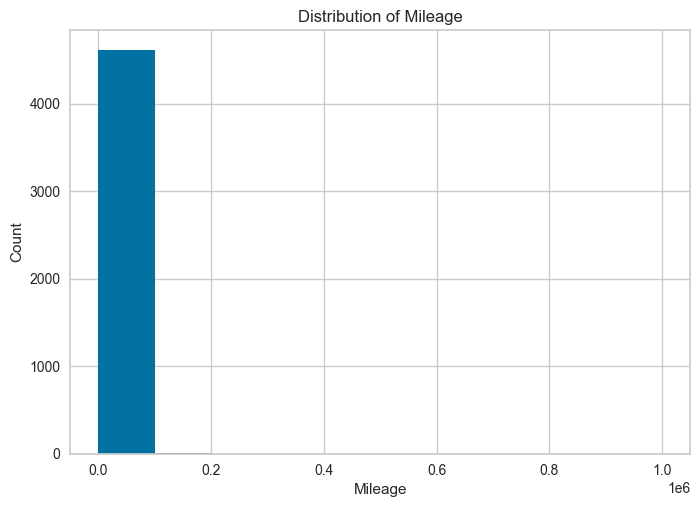

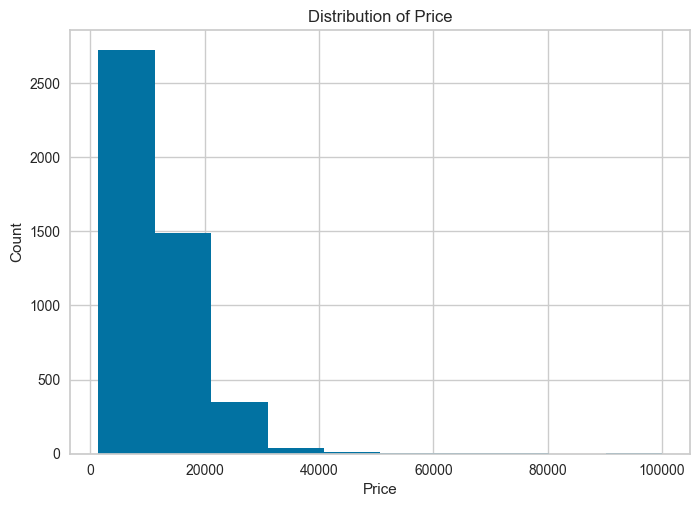

ValueError: Could not interpret input 'brand'

<Figure size 1000x600 with 0 Axes>

In [151]:
# Histogram of Price
plt.hist(df['price'], bins=10)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution of Price')
plt.show()

# Bar Plot of Motorcycle Brands
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Number of Motorcycles by Brand')
plt.xticks(rotation=90)
plt.show()

# Histogram of Motorcycle Age
plt.hist(df['old'], bins=10)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Motorcycle Age')
plt.show()

## Створення моделі, а також додаткові маніпуляції з даними
- OHE для брендів
- перетворяємо назву моделей в числа
- повикидаємо аномальні дані які будуть псувати предикт
- використовуємо інструменти для пошуку і тюнінгу найкращих моделей
- ансамбль для пошуку найкращої моделі

In [140]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(df[['brand']]).toarray())

enc_df.index = df.index

df = df.join(enc_df)
df = df.drop(columns=['brand', 'description', 'description_sentiment', 'description_sentiment_twtr', 'year'], axis=1)

freq_map = df['model'].value_counts().to_dict()
df['model'] = df['model'].map(freq_map)

df.columns = df.columns.astype(str)

Після застосування EllipticEnvelope ми визначили ще 231 аномальний запис

In [141]:
from sklearn.covariance import EllipticEnvelope

envelope = EllipticEnvelope(contamination=0.05)

envelope.fit(df)

outliers = envelope.predict(df)
df['outlier'] = outliers

print(df['outlier'].value_counts())

 1    4385
-1     231
Name: outlier, dtype: int64


In [142]:
X = df.drop(df[df['outlier'] == -1].index, axis=0)
X = X.drop(['outlier'], axis=1)

Y = X['price']
X = X.drop(['price'], axis=1)


### Pycaret - бібліотека для пошуку найкращої моделі

In [143]:
# import pycaret regression and init setup
from pycaret.regression import *

s = setup(X, target = Y, session_id = 123)

best = compare_models()

# Get you the results in a pandas dataframe (results object)
results = pull()

# Print out the results
results

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,2526.33,16595650.31,4061.44,0.62,0.32,0.24,0.09
lightgbm,Light Gradient Boosting Machine,2694.28,16905156.47,4103.19,0.61,0.34,0.28,0.06
gbr,Gradient Boosting Regressor,2865.84,17556302.55,4180.31,0.60,0.35,0.30,0.07
xgboost,Extreme Gradient Boosting,2698.74,17815519.40,4205.75,0.59,0.35,0.27,0.07
et,Extra Trees Regressor,2559.67,18097251.24,4233.78,0.58,0.33,0.25,0.08
lr,Linear Regression,3351.42,21396583.00,4620.26,0.51,0.41,0.36,0.19
lasso,Lasso Regression,3351.48,21396564.20,4620.26,0.51,0.41,0.36,0.08
ridge,Ridge Regression,3351.46,21396432.20,4620.24,0.51,0.41,0.36,0.05
llar,Lasso Least Angle Regression,3351.54,21398027.00,4620.42,0.51,0.41,0.36,0.05
lar,Least Angle Regression,3377.80,21522072.00,4634.38,0.50,0.41,0.37,0.05


Так як Random Forest Regressor, Light Gradient Boosting Machine, Gradient Boosting Regressor та Extreme Gradient Boosting - найкращі моделі продовжимо працювати з ними

In [144]:
lightgbm = create_model('lightgbm')
gbr = create_model('gbr')
xgboost = create_model('xgboost')
rf = create_model('rf')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:01:03
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2685.6187,14450261.1511,3801.3499,0.5928,0.3265,0.2769
1,2506.7822,14528752.6273,3811.6601,0.6519,0.3388,0.2803
2,2719.7519,18302602.5121,4278.1541,0.6223,0.3252,0.2569
3,2820.4274,16113083.4668,4014.1105,0.6158,0.3644,0.3126
4,2721.5512,19309063.9620,4394.2080,0.6168,0.3248,0.2579
5,2889.7832,20739052.8685,4554.0150,0.5253,0.3393,0.2731
6,2836.6048,18591641.3743,4311.8026,0.5805,0.3443,0.2803
7,2624.0597,14064229.0231,3750.2305,0.6557,0.3534,0.2970
8,2550.5976,17176638.0930,4144.4708,0.6278,0.3320,0.2650


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:01:04
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2808.8878,14653522.0912,3827.9919,0.5871,0.3473,0.3078
1,2712.3989,16037578.3400,4004.6945,0.6157,0.3642,0.3149
2,2884.8204,18012499.2564,4244.1135,0.6283,0.3400,0.2872
3,2788.6546,15642181.0720,3955.0197,0.6271,0.3675,0.3194
4,2944.3295,20498286.2598,4527.5033,0.5932,0.3483,0.2961
5,3142.0937,21597997.7519,4647.3646,0.5057,0.3560,0.3076
6,3060.4192,20148987.0961,4488.7623,0.5453,0.3692,0.3133
7,2806.5725,14657789.2137,3828.5492,0.6412,0.3774,0.3320
8,2735.6894,18364438.9770,4285.3750,0.6020,0.3398,0.2819


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:01:06
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2606.4395,16047032.5520,4005.8748,0.5478,0.3077,0.2428
1,2347.4793,14242667.2649,3773.9458,0.6587,0.3158,0.2459
2,2552.1974,17789692.8950,4217.7829,0.6329,0.3092,0.2318
3,2597.4952,15618074.2711,3951.9709,0.6276,0.3398,0.2643
4,2601.2913,19197943.7607,4381.5458,0.6190,0.3079,0.2313
5,2719.4991,19520369.4202,4418.1862,0.5532,0.3220,0.2552
6,2714.3138,19994375.6703,4471.5071,0.5488,0.3300,0.2578
7,2271.8615,11863544.1890,3444.3496,0.7096,0.3220,0.2514
8,2487.5104,17504991.3477,4183.8967,0.6206,0.3296,0.2539


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Авто тюнинг моделі

In [145]:
tune_lightgbm = tune_model(lightgbm)
tune_gbr = tune_model(gbr)
xgboost = tune_model(xgboost)
rf = tune_model(rf)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits


## Ансамбль моделей

In [147]:
from sklearn.model_selection import cross_val_score

ensemble_model = VotingRegressor(
    estimators=[('lightgbm', lightgbm), ('gbr', gbr), ('xgboost', xgboost), ('rf', rf)], weights=[1, 1, 1, 1]
)

scores = cross_val_score(ensemble_model, X, Y, cv=5)
print(scores)

[-1.04807133 -0.01089465  0.60838987  0.59736684  0.01239172]


In [148]:
ensemble_model.fit(X, Y)

VotingRegressor(estimators=[('lightgbm', LGBMRegressor(random_state=123)),
                            ('gbr',
                             GradientBoostingRegressor(random_state=123)),
                            ('xgboost',
                             XGBRegressor(base_score=None, booster='gbtree',
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.9,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None...
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=10,
                                          max_leaves=None, min_child_weight=4,
                                          missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=220, n_jobs=-1,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=123, ...)),
                            ('rf',
                             RandomForestRegressor(n_jobs=-1,
                                                   random_state=123))],
                weights=[1, 1, 1, 1])

In [149]:
preds = predict_model(ensemble_model)
preds

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,1908.3998,9350559.0563,3057.8684,0.7917,0.2427,0.1874


,mileage,model,old,0,1,2,3,4,5,price,prediction_label
1542,11353.00,1,1.00,0.00,1.00,0.00,0.00,0.00,0.00,25000.00,22055.42
1186,170.00,1,0.00,0.00,1.00,0.00,0.00,0.00,0.00,14500.00,22106.29
994,1176.00,6,4.00,0.00,1.00,0.00,0.00,0.00,0.00,8195.00,11703.53
1939,370.00,20,1.00,0.00,0.00,1.00,0.00,0.00,0.00,10999.00,10553.84
4597,12919.00,3,18.00,0.00,0.00,0.00,0.00,0.00,1.00,4285.00,4666.17
...,...,...,...,...,...,...,...,...,...,...,...
2077,8789.00,11,3.00,0.00,0.00,1.00,0.00,0.00,0.00,15270.00,14069.62
1899,1.00,10,0.00,0.00,0.00,1.00,0.00,0.00,0.00,20399.00,16120.03
3454,1930.00,24,5.00,0.00,0.00,0.00,0.00,1.00,0.00,6491.00,7443.08
3020,1.00,24,0.00,0.00,0.00,0.00,0.00,1.00,0.00,7099.00,8355.59


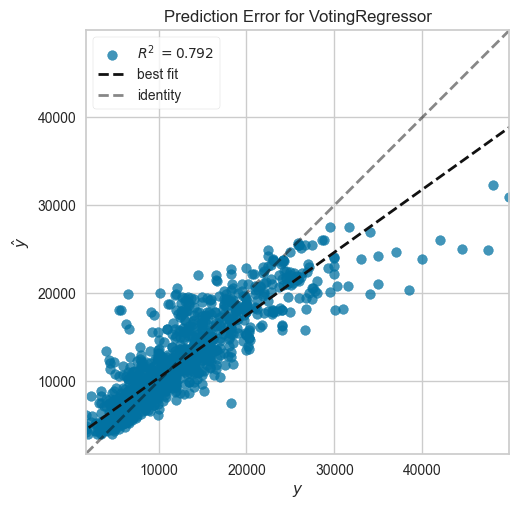

In [150]:
plot_model(ensemble_model, plot = 'error')